In [33]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [34]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [35]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


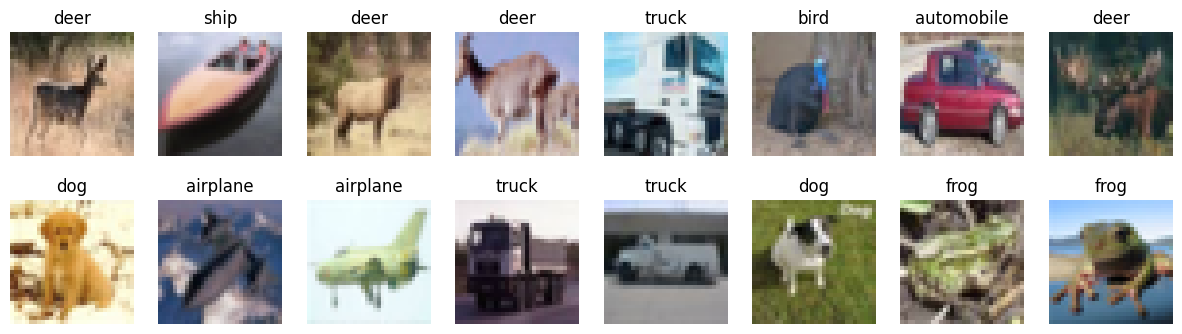

In [36]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [37]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)


In [38]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [39]:
def make_model():
    model = Sequential()

    # Convolutional Layers with Regularization and Increased Dropout
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Dense Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    return model


The neural network processes images by first using convolutional layers with kernels, which scan the image to detect patterns. These patterns help the network recognize features like edges or textures. After the first convolution, batch normalization is applied to stabilize learning.

In order to to prevent a model from becoming too complex and fitting the training data too closely (overfitting) I used regulators on my kernels.

Next, pooling layers downsample the feature maps, preserving key spatial relationships while reducing complexity. More convolutional layers with increased neurons are added to detect more detailed features. Dropout layers are introduced to prevent overfitting by randomly deactivating some neurons, ensuring the model generalizes well to unseen data.

Further convolutional layers continue refining feature extraction, followed by another pooling and batch normalization step. As the number of neurons increases, dropout rates are also adjusted to maintain model robustness.

The data is then flattened, converting it into a format suitable for dense (fully connected) layers, which learn complex relationships between features. A bottleneck layer (with fewer neurons) compresses the data, helping the model extract the most essential information.

All convolutional and dense layers use ReLU activation to introduce non-linearity, improving pattern recognition. Finally, the output layer (with softmax activation) assigns probabilities to each class, ensuring the sum is 1. The class with the highest probability is the predicted label.

In [41]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30 # Increased Epochs

model = make_model()

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=INIT_LR),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True) # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=7, min_lr=1e-6)

# Data Augmentation (Example)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

model.save_weights("myweights.weights.h5")

Epoch 1/30


/Users/nataliapaunova/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 123ms/step - accuracy: 0.3297 - loss: 1.8830 - val_accuracy: 0.2160 - val_loss: 3.0099 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 154s 123ms/step - accuracy: 0.5403 - loss: 1.3442 - val_accuracy: 0.3857 - val_loss: 1.9538 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 121ms/step - accuracy: 0.6034 - loss: 1.1964 - val_accuracy: 0.5351 - val_loss: 1.4551 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 153s 122ms/step - accuracy: 0.6459 - loss: 1.1044 - val_accuracy: 0.6303 - val_loss: 1.1428 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 121ms/step - accuracy: 0.6765 - loss: 1.0470 - val_accuracy: 0.5971 - val_loss: 1.3106 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 349s 279ms/step - accuracy: 0.6966 - loss: 1.0079 - val_accuracy: 0.5844 - val_loss: 1.4288 - learning_rate: 0.0010
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 125ms/step - acc

I thought a lower epoch would make my results more accurate judging from the graph for 15 epochs but it really does not it only makes it worse (accuracy drops by 10%!).
To avoid overfitting and prevent the model from learning detrimental parameters, early stopping terminates training when performance worsens, returning to the optimal parameter set.
Reduce LR on Plateau combats overfitting by observing validation performance. If progress stalls, signaling potential overfitting, it lowers the learning rate, allowing the model to refine its learning.
The parameters I chose for earyly_stopping and reduce_lr were chosen with advice from gemini, it shoudl reduce my overifitting problem because they were larger than the original ones I had.
I also changed my optimizer from Adamax  to Adam and it drastically increased my accuracy. It tells the model to change the learning rate based on its performance. This was inspired by Guus Beenen.

In [43]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


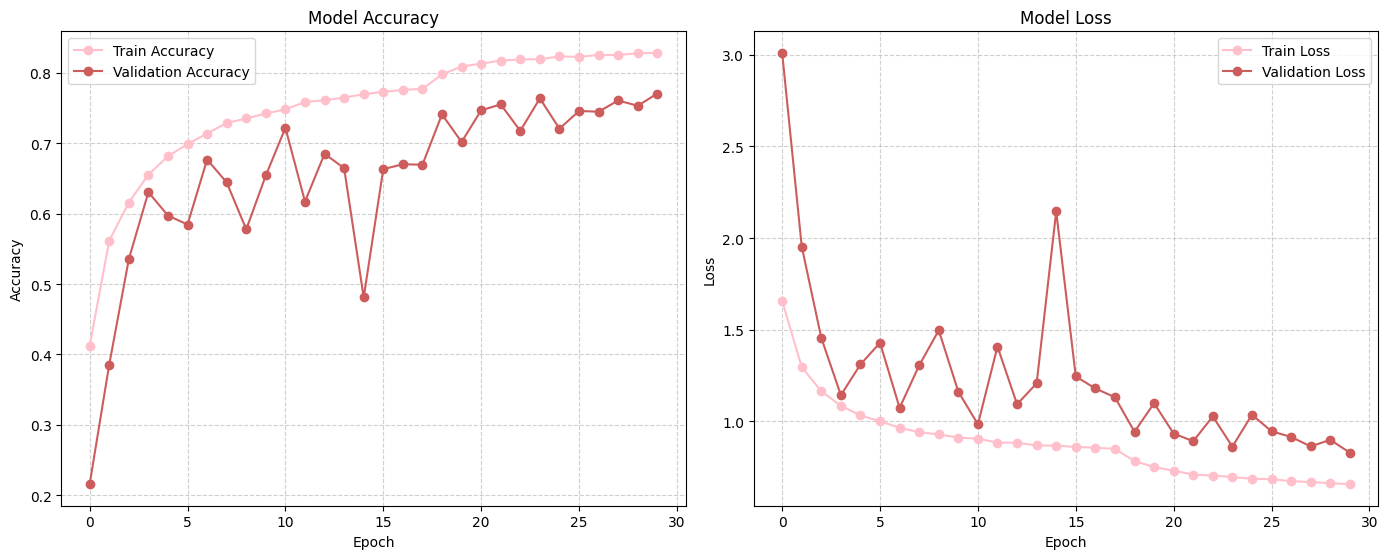

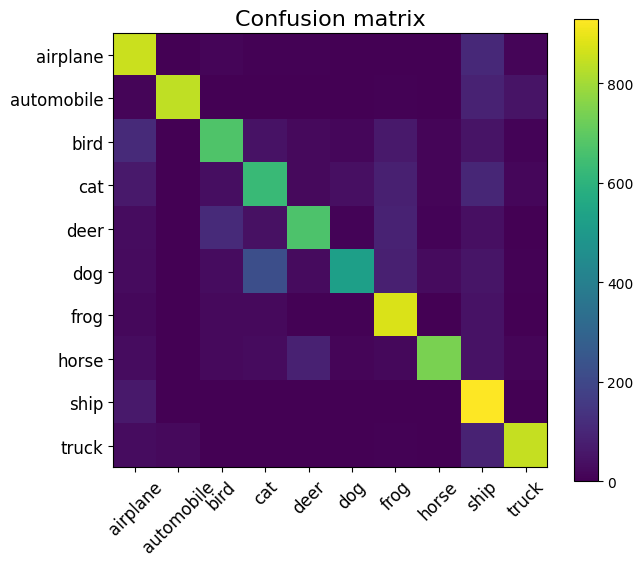

Test accuracy: 0.7576
Train accuracy: 0.869025


In [44]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)

y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_pred_train_max_probas = np.max(y_pred_train, axis=1)

y_test_index = [list(onehot).index(1) for onehot in y_test]
y_train_index = [list(onehot).index(1) for onehot in y_train]

y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# Plot training & validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linestyle='-', color = 'pink')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', color = 'indianred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', linestyle='-', color = 'pink')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='-', color = 'indianred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))
print("Train accuracy:", accuracy_score(y_train_index, y_pred_train_classes))


The model demonstrates good enough predictive performance, achieving approximately 75% accuracy on unseen test data, although this is lower than the training accuracy, indicating potential overfitting. The confusion matrix shows a clear diagonal line, suggesting effective predictions overall.

I also clearly have an issue at 14 epoches.

The accuracy and loss function plots reveal that while the training data shows smooth performance, the validation data fluctuates more, further indicating overfitting. 

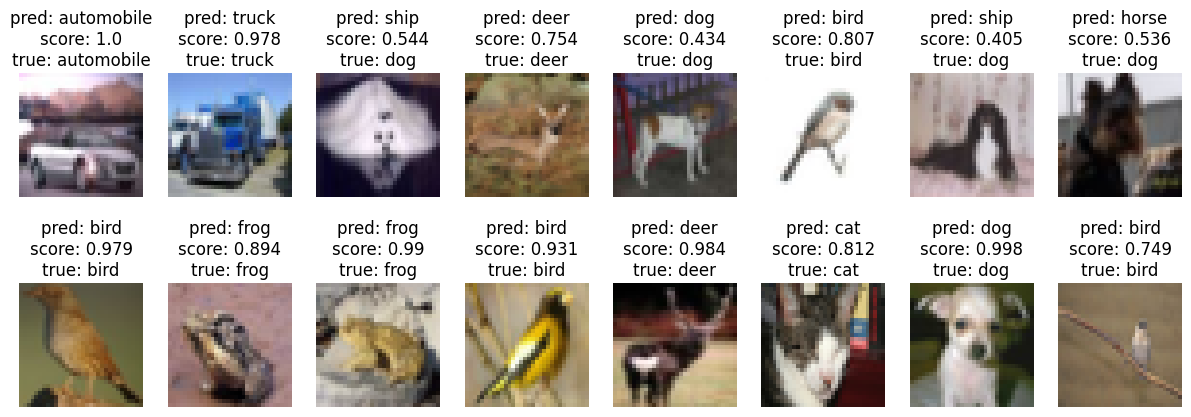

In [45]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


